# Problem set 2 (145 pts)

## Problem 1 (LU decomposition) 25 pts

## 1.
### LU for band matrices (7 pts)

The complexity to find an LU decomposition of a dense $n\times n$ matrix is $\mathcal{O}(n^3)$.
Significant reduction in complexity can be achieved if the matrix has a certain structure, e.g. it is sparse. 
In the following task we consider an important example of $LU$ for a special type of sparse matrices –– band matrices with the bandwidth $m$ equal to 3 or 5 which called tridiagonal and pentadiagonal respectively.

- (5 pts) Write a function ```band_lu(diag_broadcast, n)``` which computes LU decomposition for tridiagonal or pentadiagonal matrix with given diagonal values. 
For example, input parametres ```(diag_broadcast = [4,-2,1], n = 4)``` mean that we need to find LU decomposition for the triangular matrix of the form:

$$A = \begin{pmatrix}
-2 & 1 & 0 & 0\\
4 & -2 & 1 & 0 \\
0 & 4 & -2 & 1 \\
0 & 0 & 4 & -2 \\
\end{pmatrix}.$$

As an output it is considered to make ```L``` and ```U``` - 2D arrays representing diagonals in factors $L$ (```L[0]``` keeps first lower diagonal, ```L[1]``` keeps second lower, ...), and $U$ (```U[:,0]``` keeps main diagonal, ```U[:,1]``` keeps first upper, ...).
- (2 pts) Compare execution time of the band LU decomposition using standard function from ```scipy```, i.e. which takes the whole matrix and does not know about its special structure, and band decomposition of yours implementation. Comment on the results.

In [1]:
!pip install numpy==1.16.4 scipy==1.3.0

In [2]:
import numpy as np
from scipy.sparse import diags, coo_matrix, issparse
# can be used with broadcasting of scalars if desired dimensions are large
import scipy.linalg as la

### 1.1

In [3]:
# INPUT : diag_broadcast - list of diagonals value to broadcast,length equal to 3 or 5; 
#         n - integer, band matrix shape.
# OUTPUT : L - 2D np.ndarray, L.shape[0] depends on bandwidth, L.shape[1] = n-1, 
#              do not store main diagonal, where all ones;                  
#              add zeros to the right side of rows to handle with changing length of diagonals.
#          U - 2D np.ndarray, U.shape[0] = n, U.shape[1] depends on bandwidth;
#              add zeros to the bottom of columns to handle with changing length of diagonals.

def band_lu(diag_broadcast, n):
    m = len(diag_broadcast)
    assert m == 3 or m == 5, 'Wrong diag_broadcast dim!'

    L = np.zeros((m//2, n-1))
    U = np.zeros((n, m//2+1))

    if m == 3:
        a, b, c = diag_broadcast

        U[0, 0] = b
        U[:-1, -1] = c * np.ones(n-1)
        L[0, :] = a * np.ones(n-1)

        for i in range(n-1):
            assert not np.isclose(U[i, 0], 0, atol=1e-5), 'Singular matrix'
            L[0, i] /= U[i, 0]
            U[i+1, 0] = b - L[0, i] * c

    if m == 5:
        a, b, c, d, e = diag_broadcast

        L[1, :] = a * np.ones(n-1)
        U[:-2, -1] = e * np.ones(n-2)

        U[0, :2] = c, d
        L[0, 0] = b / U[0, 0]

        U[1, :2] = c - b*U[0, 1] / U[0, 0], d - b*e / U[0, 0]

        for i in range(n-2):
            assert not (np.isclose(U[i, 0], 0, atol=1e-5) and
                        np.isclose(U[i+1, 0], 0, atol=1e-5)), 'Singular matrix'

            L[1, i] /= U[i, 0]
            L[0, i+1] = (b - a*U[i, 1] / U[i, 0]) / U[i+1, 0]

            X = b - a*U[i, 1] / U[i, 0]
            U[i+2, 0] = c - X*U[i+1, 1] / U[i+1, 0] - a*U[i, 2] / U[i, 0]
            U[i+2, 1] = d - X*U[i+1, 2] / U[i+1, 0]

    return L, U

In [4]:
# Your solution is here
diag_broadcast = [1, -4, 7, 2, 3]
n = 6
L, U = band_lu(diag_broadcast, n)

#### Let's check result

In [5]:
L_offsets = [-1] if len(diag_broadcast) == 3 else [-1, -2]
U_offsets = [0, 1] if len(diag_broadcast) == 3 else [0, 1, 2]
A_diags = [-1, 0, 1] if len(diag_broadcast) == 3 else [-2, -1, 0, 1, 2]

L_dense = diags(L, offsets=L_offsets).toarray() + np.eye(n)
U_dense = diags(U.T, offsets=U_offsets).toarray()
A_dense = diags(diag_broadcast, A_diags, shape=(n, n)).toarray()

assert np.isclose(L_dense @ U_dense, A_dense).all(), 'Wrong LU decomposition'
print('OK!')

OK!


### 1.2

In [6]:
n = 10000
A_dense = diags(diag_broadcast, A_diags, shape=(n, n)).toarray()

%timeit la.lu(A_dense)
%timeit band_lu(diag_broadcast, n)

10.6 s ± 534 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
276 ms ± 5.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


- We can see, that our LU decomposition for band matrices much more efficient. The complexity to find an LU decomposition of a dense $n\times n$ matrix is $\mathcal{O}(n^3)$, but for band matrix - $\mathcal{O}(nb^2)$, where $b$ is bandwidth.

##  2.
### Stability of LU (8 pts)

Let
$A = \begin{pmatrix}
\varepsilon & 1 & 0\\
1 & 1 & 1 \\
0 & 1 & 1
\end{pmatrix}.$ 
* (5 pts) Find analytically LU decomposition with and without pivoting for the matrix $A$.
* (3 pts) Explain, why can the LU decomposition fail to approximate factors $L$ and $U$ for $|\varepsilon|\ll 1$ in computer arithmetic?

In [7]:
# Your solution is here

### 2.1
$A = \begin{pmatrix}
\varepsilon & 1 & 0\\
1 & 1 & 1 \\
0 & 1 & 1
\end{pmatrix} = 
\begin{pmatrix}
1 & 0 & 0\\
* & 1 & 0 \\
* & * & 1
\end{pmatrix} 
\begin{pmatrix}
* & * & *\\
0 & * & * \\
0 & 0 & *
\end{pmatrix}= 
\begin{pmatrix}
1 & 0 & 0\\
* & 1 & 0 \\
* & * & 1
\end{pmatrix} 
\begin{pmatrix}
\varepsilon & 1 & 0\\
0 & * & * \\
0 & 0 & *
\end{pmatrix}= 
\begin{pmatrix}
1 & 0 & 0\\
\varepsilon^{-1} & 1 & 0 \\
* & * & 1
\end{pmatrix} 
\begin{pmatrix}
\varepsilon & 1 & 0\\
0 & 1-\varepsilon^{-1} & 1 \\
0 & 0 & *
\end{pmatrix}=$


$=\begin{pmatrix}
1 & 0 & 0\\
\varepsilon^{-1} & 1 & 0 \\
0 & \frac{\varepsilon}{\varepsilon-1} & 1
\end{pmatrix} 
\begin{pmatrix}
\varepsilon & 1 & 0\\
0 & 1-\varepsilon^{-1} & 1 \\
0 & 0 & \frac{1}{1-\varepsilon}
\end{pmatrix}$ 

$$L = \begin{pmatrix}
1 & 0 & 0\\
\varepsilon^{-1} & 1 & 0 \\
0 & \frac{\varepsilon}{\varepsilon-1} & 1
\end{pmatrix};   U = \begin{pmatrix}
\varepsilon & 1 & 0\\
0 & 1-\varepsilon^{-1} & 1 \\
0 & 0 & \frac{1}{1-\varepsilon}
\end{pmatrix} 
$$



Let `P` be a permutation matrix, such that
$P = \begin{pmatrix}
0 & 1 & 0\\
1 & 0 & 0 \\
0 & 0 & 1
\end{pmatrix}$  then   $PA = \begin{pmatrix}
1 & 1 & 1 \\
\varepsilon & 1 & 0\\
0 & 1 & 1
\end{pmatrix}.$

$PA = \begin{pmatrix}
1 & 1 & 1 \\
\varepsilon & 1 & 0\\
0 & 1 & 1
\end{pmatrix} = 
\begin{pmatrix}
1 & 0 & 0\\
* & 1 & 0 \\
* & * & 1
\end{pmatrix} 
\begin{pmatrix}
* & * & *\\
0 & * & * \\
0 & 0 & *
\end{pmatrix}= 
\begin{pmatrix}
1 & 0 & 0\\
\varepsilon & 1 & 0 \\
* & * & 1
\end{pmatrix} 
\begin{pmatrix}
1 & 1 & 1\\
0 & 1-\varepsilon & -\varepsilon \\
0 & 0 & *
\end{pmatrix} =
\begin{pmatrix}
1 & 0 & 0\\
\varepsilon & 1 & 0 \\
0 & (1-\varepsilon)^{-1} & 1
\end{pmatrix} 
\begin{pmatrix}
1 & 1 & 1\\
0 & 1-\varepsilon & -\varepsilon \\
0 & 0 & (1-\varepsilon)^{-1}
\end{pmatrix}$ 


$$L = \begin{pmatrix}
1 & 0 & 0\\
\varepsilon & 1 & 0 \\
0 & (1-\varepsilon)^{-1} & 1
\end{pmatrix};   U = \begin{pmatrix}
1 & 1 & 1\\
0 & 1-\varepsilon & -\varepsilon \\
0 & 0 & (1-\varepsilon)^{-1}
\end{pmatrix}
$$

Without pivoting:
- This problem does not arise because we work with numbers of order $\varepsilon$ and  $1-\varepsilon \approx (1-\varepsilon)^{-1} \approx 1$

In [8]:
# Example
print('Float32:', np.float32(1e-4+1e3), np.float32(1e-4+1e4))
print('Float64:', np.float64(1e-8+1e8), np.float64(1e-8+1e9))

Float32: 1000.0001 10000.0
Float64: 100000000.00000001 1000000000.0


In [9]:
# Example
print('Float32:', np.float32(1e-4+1e3), np.float32(1e-4+1e4))
print('Float64:', np.float64(1e-8+1e8), np.float64(1e-8+1e9))

Float32: 1000.0001 10000.0
Float64: 100000000.00000001 1000000000.0


With pivoting:
- By matrix product L and U we have to add $\varepsilon$ and $\varepsilon^{-1}$. For example, the `float32` has 7 significant digits and `float64` has 16 significant digits. If $|\varepsilon|\ll 1$ we may loss accuracy.

In [10]:
# Example
eps = 1e-7
print('Float32:', np.float64(1-eps), np.float64(1/(1-eps)))

Float32: 0.9999999 1.00000010000001


## 3. 
### Block LU (10 pts)

Let $A = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix}$ be a block matrix. The goal is to solve the linear system

$$
     \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} = \begin{bmatrix} f_1 \\ f_2 \end{bmatrix}.
$$

* (2 pts) Using block elimination find matrix $S$ and right-hand side $\hat{f_2}$ so that $u_2$ can be found from $S u_2 = \hat{f_2}$. Note that the matrix $S$ is called <font color='red'> Schur complement </font> of the block $A_{11}$.
* (4 pts) Using Schur complement properties prove that 

$$\det(X+AB) = \det(X)\det(I+BX^{-1}A), $$


where $X$ - nonsingular square matrix.
* (4 pts) Let matrix $F \in \mathbb{R}^{m \times n}$ and $G \in \mathbb{R}^{n \times m}$. Prove that 

$$\det(I_m - FG) = \det(I_n - GF).$$

In [11]:
# Your solution is here

### 3.1
 $
     \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} = \begin{bmatrix} f_1 \\ f_2 \end{bmatrix}$ the same as $\begin{cases} A_{11} u_1 + A_{12}u_2 = f_1 \\ 
     A_{21}u_1 + A_{22}u_2 = f_2 \end{cases}.$

Assume that $A_{11}$ is non-singular matrix then multiply the first equation by $A_{21}A_{11}^{-1}$ and subtract the first from the second:

$$\left(A_{22} - A_{21}A_{11}^{-1}A_{12}\right)u_2 = f_2 - A_{21}A_{11}^{-1}f_1$$

So $$\begin{cases} S = A_{22} - A_{21}A_{11}^{-1}A_{12} \\ 
                  \hat{f_2} = f_2 - A_{21}A_{11}^{-1}f_1 \end{cases}.$$

### 3.2
$$det(X + AB) = det\left(\begin{pmatrix}
I & -B \\ 
A & X \\ 
\end{pmatrix}
\begin{pmatrix}
I & B \\ 
0 & I \\ 
\end{pmatrix}
\right) = det\begin{pmatrix}
I & 0 \\ 
A & X+AB \\ 
\end{pmatrix} = det\begin{pmatrix}
I & -B \\ 
A & X \\ 
\end{pmatrix}
$$


$$det\begin{pmatrix}
I & -B \\ 
A & X \\ 
\end{pmatrix} = det\left(\begin{pmatrix}
I & -B \\ 
A & X \\ 
\end{pmatrix}
\begin{pmatrix}
I & 0 \\ 
-X^{-1}A & I \\ 
\end{pmatrix}
\right) = det\begin{pmatrix}
I+BX^{-1}A & -B \\ 
0 & X \\ 
\end{pmatrix} = det(X)det(I+BX^{-1}A)$$


### 3.3
Using result from 3.2:
$$\det(I_m - FG) = det\begin{pmatrix}
I_n & G \\ 
F & I_m \\ 
\end{pmatrix} = det(I_m)det(I_n-GI_m^{-1}F) = det(I_n - GF)$$

## Problem 2 (QR decomposition) 30 pts

## 1.
###  Standard Gram-Schmidt algorithm (18 pts)
Our goal is to orthogonalize a system of linearly independent vectors $v_1,\dots,v_n$.
The standard algorithm for this task is the Gram-Schmidt process:

$$
\begin{split}
u_1 &= v_1, \\
u_2 &= v_2 - \frac{(v_2, u_1)}{(u_1, u_1)} u_1, \\
\dots \\
u_n &= v_n - \frac{(v_n, u_1)}{(u_1, u_1)} u_1 - \frac{(v_n, u_2)}{(u_2, u_2)} u_2 - \dots - \frac{(v_n, u_{n-1})}{(u_{n-1}, u_{n-1})} u_{n-1}.
\end{split}
$$

Obtained $u_1, \dots, u_n$ are orthogonal vectors in exact arithmetics. Then to make the system orthonormal you should divide each of the vectors by its norm: $u_i := u_i/\|u_i\|$.
The Gram-Schmidt process can be considered as a QR decomposition. Let us show that.

* (2 pts) Write out what is matrices $Q$ and $R$ obtained in the process above. 

* (5 pts) Implement the described Gram-Schmidt algorithm as a function ```gram_schmidt_qr(A)``` that takes a rectangular matrix ```A``` and outputs ```Q,R```.

* (3 pts) Create a rectangular matrix $K = [x, Ax, A^2x, \ldots, A^kx]$ where $A \in \mathbb{R}^{100 \times 100}$ is a random matrix and $x$ is a random vector of the appropriate dimension, $k = 20$.  
The loss of orthogonality can be described by the following error: $\|Q^{\top}Q-I\|_2$, where $Q^{\top}Q$ is called a Gram matrix. Compute QR decomposition of the created matrix $K$ with function that you have implemented and calculate error $\|Q^{\top}Q-I\|_2$. Comment on the result.

* (5 pts) The observed loss of orthogonality is a problem of this particular algorithm. Luckily, there is [a simple improvement to the algorithm above](https://en.wikipedia.org/wiki/Gram–Schmidt_process#Numerical_stability) that reduces the loss of orthogonality. Implement this modification as a function ```modified_gram_schmidt_qr(A)``` such that input and output are similar to ```gram_schmidt_qr(A)```. 
* (3 pts) Compute QR decomposition of the matrix $K$ from the previous task with the function ```modified_gram_schmidt_qr(A)```.
Compute error $\|Q^{\top}Q-I\|_2$. Compare this error to the error obtained with a "pure" Gram-Schmidt and comment on the result.

### 1.1

Let $A = (a_1, \dots, a_n)$ be a matrix $n\times n$, where $a_i$ are columns of matrix $A$. We will create matrix $Q$ such that $QQ^* = Q^*Q = I$ *(Q is unitary)*.

Using Gram-Schmidt process we will create from set of vectors $a_i$ orthonormal set of vectors $e_i$ and let $Q = (e_1, \dots, e_n)$ and $R = Q^*A$, where R will be upper-triangular matrix

### 1.2 & 1.4

In [12]:
import numpy.linalg as LA
# INPUT : rectangular matrix A
# OUTPUT: matrices Q - orthogonal and R - upper triangular such that A = QR
def gram_schmidt_qr(A): # 5 pts
    # your code is here
    m, n = A.shape
    min_dim = min(n, m)
    Q = A[:, :min_dim].copy()

    for i in range(0, min_dim):
        Q[:, i] -= sum((A[:, i] @ Q[:, j])*Q[:, j]  for j in range(i))
        Q[:, i] /= LA.norm(Q[:, i])

    R = Q.T @ A

    return Q, R


# INPUT : rectangular matrix A
# OUTPUT: matrices Q - orthogonal and R - upper triangular such that A = QR
def modified_gram_schmidt_qr(A): # 5 pts
    # your code is here
    m, n = A.shape
    min_dim = min(n, m)
    Q = A[:, :min_dim].copy()
    
    for i in range(0, min_dim):
        for j in range(i):
            Q[:, i] -= (Q[:, i] @ Q[:, j])*Q[:, j]
        Q[:, i] /= LA.norm(Q[:, i])
    
    R = Q.T @ A
    
    return Q, R

### 1.3 & 1.5

In [13]:
n = 100
A = np.random.rand(n, n)
x = np.random.rand(n, 1)

Q1, R1 = gram_schmidt_qr(A)
Q2, R2 = modified_gram_schmidt_qr(A)

assert np.isclose(Q1@R1, A).all(), 'Wrong QR decomposition'
assert np.isclose(Q2@R2, A).all(), 'Wrong QR decomposition'
print('OK!')

OK!


In [14]:
k = 20
K = np.hstack([LA.matrix_power(A, i)@x for i in range(k+1)])

Q1, R1 = gram_schmidt_qr(K)
Q2, R2 = modified_gram_schmidt_qr(K)

I = np.eye(k+1)
print(LA.norm(Q1.T@Q1 - I, ord=2))
print(LA.norm(Q2.T@Q2 - I, ord=2))

12.982864247687461
0.905983813302063


In [15]:
K.min(), K.max()

(0.019938230341648655, 5.1675893057489414e+33)

- It's a typical floating-point arithmetic problem. The matrix $K$ numbers have too different orders, which is why rounding errors occur. The modified algorithm is more resistant to this.

## 2.
### Updating QR decompositions (12 pts)

Suppose we are dealing with overdetermined system:

$$ Ax = y, \;\; A \in \mathbb{R}^{m \times n}, \;\;  m \geq n. $$

If you were attentive during the course, you should be aware of 
the canonical way to solve this system. 

- No, implementing **Householder $QR$** will not be your task :)

- We assume that $QR$ decomposition of $A$ **is given**:

$$ QR = A = \begin{bmatrix}a_1 & a_2 & \ldots & a_n \end{bmatrix}, \;\; a_i \in \mathbb{R}^m,$$

where $Q \in \mathbb{R}^{m \times m}$ is unitary matrix and $R \in \mathbb{R}^{m \times n}$ is upper triangular.

- Let $k$ be an arbitrary column index, $1 \leq k \leq n$, and $z \in \mathbb{R}^{m}$ be an arbitrary vector.

We are interested in matrices:

$$ \tilde{A} = \begin{bmatrix}a_1 & \ldots & a_{k-1} & a_{k+1} & \ldots a_n \end{bmatrix} \in \mathbb{R}^{m \times (n-1)},$$

and:

$$ \hat{A} = \begin{bmatrix}a_1 & \ldots & a_{k} & z & a_{k+1} & \ldots a_n \end{bmatrix} \in \mathbb{R}^{m \times (n+1)},$$

which are obtained by deleting / inserting one column from / to the matrix $A$.

For example, if $A$ comes from a least-squares problem, such matrices appear if one wants to examine the significance of the $k^{th}$ parameter in the underlying model (e.g. think in terms of linear regression).

- We want to compute decompostions of these updated matrices:

$$ \tilde{A} = \tilde{Q}\tilde{R}, \;\; \hat{A} = \hat{Q}\hat{R}. $$

Performing full orthogonalization process will be redundant. Instead, the known $QR$ factors of $A$ should be **updated** in a proper way.

- Different methods for performing $QR$ decomposition were studied during the course. We expect the factors of updated matrices can be recovered with a small number of selective updates, hence the **Givens rotations** seem to be the most appropriate.

- Recall the Givens rotation matrix :

$$G_{ij}(\theta) = \begin{bmatrix} 
1      & \ldots & 0      & \ldots & 0      & \ldots & 0      \\
\vdots & \ddots & \vdots &        & \vdots &        & \vdots \\
0      & \ldots & c      & \ldots & s      & \ldots & 0      \\
\vdots &        & \vdots & \ddots & \vdots &        & \vdots \\
0      & \ldots & -s     & \ldots & c      & \ldots & 0      \\
\vdots &        & \vdots &        & \vdots & \ddots & \vdots \\
0      & \ldots & 0      & \ldots & 0      & \ldots & 1      
\end{bmatrix}  \;\; \in \mathbb{R}^{m \times m}, \;\; c = \cos \theta, \;\; s = \sin \theta,$$ 

which differs from the identity $\mathrm{I}^{m \times m}$ by a $2 \times 2$ sub-matrix:

$$
{G}(\theta) = \begin{bmatrix} c & s \\ -s & c \end{bmatrix} \in \mathbb{R}^{2 \times 2},
$$
placed on the rows and columns with indices $i$ and $j$. 

1. (1 pts)
Matrix ${G}$ has clear geometric interpretation in 2 dimensions. Let  $a = \begin{pmatrix} a_1 \\ a_2 \end{pmatrix} \in \mathbb{R}^2$ be an arbitrary non-zero vector. According to the template provided below, implement the function to construct matrix $G$, such that:

$$ {G}^T \begin{pmatrix} a_1 \\ a_2 \end{pmatrix} = \begin{pmatrix} \alpha \\ 0 \end{pmatrix}.$$

### 2.1
What are geometrical meanings of $\alpha$ and $\theta$? 
- The $\alpha$ is vector which will turn on $-\theta$, where $\theta$ is the angle between $\alpha$ and OX.

In [16]:
def givens(a):
    '''
    Input: 
        a: np.array of size (2)
    Output: 
        G: np.array of size (2, 2)
            Rotation matrix, G^T eliminates the second component of a
    '''

    # Your code is here
    
    r = LA.norm(a)
    G = [[a[0], -a[1]], 
         [a[1], a[0]]]
    G = np.asarray(G) / r
    return G
    
# Check yourself 
a = np.random.rand(2)
givens(a).T.dot(a) 

array([5.41627930e-01, 2.82400204e-17])

- Similarly, matrix $G_{ij}$ can be constructed in order to eliminate the $j^{th}$ component of an arbitrary vector of size $m$. This leads to the well-known **Givens $QR$ algorithm** (see lecture notes!).

- Givens rotations typically appear in matrix form:

$$ G_{ij}^T X, \;\; X^{'}G_{ij},$$

where $X$ and $X^{'}$ are some matrices with compatible sizes, e.g. intermediate factors in the **Givens $QR$ algorithm**. 

How to perform these multiplications efficiently? 
Obviously, $G_{ij}$ does not need to be stored in explicit form. It affects only two rows / columns, hence only appropriate submatrices should be modified.

2. (5 pts) Your second task is to propose an efficient procedure for computing $\tilde{Q}, \tilde{R}$ factors of $\tilde{A}$ by a proper update of $Q, R$ factors of $A$. 

Hint: consider the following block partition of $R$ (assuming $k^{th}$ column deleted):
$$ R = 
\begin{bmatrix} 
R_{11} & v & R_{13} \\
0 & r_{kk} & \omega^T \\
0 & 0 & R^{33}
\end{bmatrix},
$$
and note, that:
$$Q^T\tilde{A} = 
\begin{bmatrix}
R_{11} & R_{13} \\
0 & \omega^T \\
0 & R_{33}
\end{bmatrix} = H.$$

- (2 pts) What structure has matrix $H$ and how does it help in understanding the proper way to compute updated QR decomposition?

- (3 pts) Implement the function according to the template provided below.
Use Givens matrices $G_{ij}$ with $j = i+1$ for the convinience.

- Only one loop over non-zero subdiagonal elements of $H$ is allowed. You are supposed to perform computations in a proper vectorized form. For example, the *in-place* multiplication $G_{ij}^T X$ with a random matrix $X \in \mathbb{R}^{m \times n}$ can be implemented as follows: ```X[[i,j],:] = G.T.dot(X[[i,j],:])```. 

- Do not modify elements which are known to be zero.


### 2.2
What structure has matrix $H$ and how does it help in understanding the proper way to compute updated QR decomposition?
- The matrix $H$ looks like $\begin{pmatrix}
* & * & * & * & * \\
0 & * & * & * & * \\
0 & 0 & * & * & * \\
0 & 0 & * & * & * \\
0 & 0 & 0 & * & * \\
\end{pmatrix}$.

We should make this matrix an upper-triangular using Givens rotation. 

$\hat{R} = G_1 \cdot \dots \cdot G_k H = G H$, where $\hat{R}$ is upper-triangular matrix.

$\hat{Q} = Q G_k^T \cdot \dots \cdot G_1^T= Q G^T .$

$\hat{A} = \hat{Q}\hat{R}$, where A is a matrix without some column.

In [17]:
def delete_column_QR(A, k):
    '''
    Input: 
        A: np.array of size (m, n) 

        k: positive integer
            Index of deleted column, 0 \leq k \leq n - 1

    Output: 
        Q: np.array of size (m, m)

        R: np.array of size (m, n - 1)

    '''
    Q, R = np.linalg.qr(A, mode='complete') # factors of $A$ are know
    R = np.delete(R, k, axis=1) # delete column

    m, n = R.shape
    items = n if m > n else m-1

    for i in range(k, items):
        G = givens(R[i:i+2, i])
        R[i:i+2, i:] = G.T @ R[i:i+2, i:]
        Q[:, i:i+2] = Q[:, i:i+2] @ G

    # Your code is here
    return Q, R


# Check yourself
m, n = (200, 100)
A = np.random.rand(m, n)
k = np.random.randint(0, n)

A_tilde = np.delete(A, k, axis=1)
Q_tilde, R_tilde = delete_column_QR(A, k)

assert np.isclose(A_tilde, Q_tilde.dot(R_tilde)).all(), 'Wrong QR decomposition'
print('OK!')

OK!


### 2.3

3. (3 pts) When a column is inserted, the factors $\hat{Q}, \hat{R}$ of $\hat{A}$ again can be computed efficiently by a proper update of $Q, R$ factors of $A$.


- Proceed similarly to the previous task. Implement the function according to the template provided below. 

- Choose optimal order of elimination to minimize the number of rotations.

In [18]:
def insert_column_QR(A, k, z):
    '''
    Input: 
        A: np.array of size (m, n) 

        k: positive integer
            Index of inserted column, 0 \leq k leq n - 1

        z: np.array of size (m)
            Inserted column

    Output: 
        Q: np.array of size (m, m)
        
        R: np.array of size (m, n + 1)
    '''
    Q, R = np.linalg.qr(A, mode='complete') # factors of $A$ are known
    R = np.hstack((R[:, :k], (Q.T @ z)[:, np.newaxis], R[:, k:]))
    # Your code is here

    for i in reversed(range(k+2, R.shape[0]+1)):
        G = givens(R[i-2:i, k])
        R[i-2:i, k:] = G.T @ R[i-2:i, k:]
        Q[:, i-2:i] = Q[:, i-2:i] @ G

    return Q, R


# Check yourself
m, n = (200, 100)
A = np.random.rand(m, n)
k = np.random.randint(0, n)
z = np.random.rand(m)

A_hat = np.insert(A, k, z, axis=1)
Q_hat, R_hat = insert_column_QR(A, k, z)

assert np.isclose(A_hat, Q_hat.dot(R_hat)).all(), 'Wrong QR decomposition'
print('OK!')

OK!


4. (3 pts) In the context of least-squares problems, appending rows to a matrix is just as important as inserting columns (e.g. new samples in linear regression).

Consider matrix:

$$ \overline{A} = \begin{bmatrix} \omega^T \\ A \end{bmatrix} \in \mathbb{R}^{(m+1) \times n},$$

which is obtained by appending a row $\omega^T \in \mathbb{R}^{n}$ to the matrix $A$.

Similarly to the previous tasks, you need to compute $\overline{Q}, \overline{R}$ factors of $\overline{A}$ by a proper update of $Q,R$ factors of $A$.

- Implement the function according to the template provided below. Your code is still expected to be efficient!

In [19]:
def insert_row_QR(A, w):
    '''
    Input: 
        A: np.array of size (m, n)

        w: np.array of size (n)
            Inserted row
        
    Output:
        Q: np.array of size (m + 1, m + 1)
        
        R: np.array of size (m + 1, n)
    '''
    m, n = A.shape
    Q, R = np.linalg.qr(A, mode='complete')
    # Your code is here
    
    Q = np.hstack((np.zeros(m)[:, np.newaxis], Q))
    Q = np.vstack((np.zeros(m+1), Q))
    Q[0, 0] = 1
    R = np.vstack((w, R))
    
    for i in range(min(n, m)):
        G = givens(R[i:i+2, i])
        R[i:i+2, i:] = G.T @ R[i:i+2, i:]
        Q[:, i:i+2] = Q[:, i:i+2] @ G
        
    return Q, R


# Check yourself
m, n = (200, 100)
A = np.random.rand(m, n)
w = np.random.rand(n)

A_overline = np.insert(A, 0, w, axis=0)
Q_overline, R_overline = insert_row_QR(A, w)

assert np.isclose(A_overline, Q_overline.dot(R_overline)).all(), 'Wrong QR decomposition'
print('OK!')

OK!


## Problem 3 (Word2Vec as Matrix Factorization) 45 pts

In this assignment you are supposed to apply SVD to training your own [word embedding model](https://en.wikipedia.org/wiki/Word_embedding) which maps English words to vectors of real numbers.

Skip-Gram Negative Sampling (SGNS) word embedding model, commonly known as **word2vec** ([Mikolov et al., 2013](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)), is usually optimized by stochastic gradient descent. However, the optimization of SGNS objective can be viewed as implicit matrix factorization objective as was shown in ([Levy and Goldberg, 2015](http://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization.pdf)).

###### 1. Notation
Assume we have a text corpus given as a sequence of words $\{w_1,w_2,\dots,w_n\}$ where $n$ may be larger than $10^{12}$ and $w_i \in \mathcal{V}$ belongs to a vocabulary of words $\mathcal{V}$. A word $c \in \mathcal{V}$ is called *a context* of word $w_i$ if they are found together in the text. More formally, given some measure $L$ of closeness between two words (typical choice is $L=2$), a word $c \in \mathcal{V}$ is called a context if $c \in \{w_{i-L}, \dots, w_{i-1}, w_{i+1}, \dots, w_{i+L} \}$ Let $\mathbf{w},\mathbf{c}\in\mathbb{R}^d$ be the *word embeddings* of word $w$ and context $c$, respectively. Assume they are specified by the mapping  $\Phi:\mathcal{V}\rightarrow\mathbb{R}^d$, so $\mathbf{w}=\Phi(w)$. The ultimate goal of SGNS word embedding model is to fit a good mapping $\Phi$.

Let $\mathcal{D}$ be a multiset of all word-contexts pairs observed in the corpus. In the SGNS model, the probability that word-context pair $(w,c)$ is observed in the corpus is modeled as the following distribution:

$$
P(\#(w,c)\neq 0|w,c) = \sigma(\mathbf{w}^\top \mathbf{c}) = \frac{1}{1 + \exp(-\mathbf{w}^\top \mathbf{c})},
$$

where $\#(w,c)$ is the number of times the pair $(w,c)$ appears in $\mathcal{D}$ and $\mathbf{w}^\top\mathbf{c}$ is the scalar product of vectors $\mathbf{w}$ and $\mathbf{c}$. Two important quantities which we will also use further are the number of times the word $w$ and the context $c$ appear in $\mathcal{D}$, which can be computed as

$$
\#(w) = \sum_{c\in\mathcal{V}} \#(w,c), \quad \#(c) = \sum_{w\in\mathcal{V}} \#(w,c).
$$


###### 2. Optimization objective

Vanilla word embedding models are trained by maximizing log-likelihood of observed word-context pairs, namely

$$
\mathcal{L} = \sum_{w \in \mathcal{V}} \sum_{c \in \mathcal{V}} \#(w,c) \log \sigma(\mathbf{w}^\top\mathbf{c}) \rightarrow \max_{\mathbf{w},\mathbf{c} \in \mathbb{R}^d}.
$$

Skip-Gram Negative Sampling approach modifies the objective by additionally minimizing the log-likelihood of random word-context pairs, so called *negative samples*. This idea incorporates some useful linguistic information that some number ($k$, usually $k=5$) of word-context pairs *are not* found together in the corpus which usually results in word embeddings of higher quality. The resulting optimization problem is

$$
\mathcal{L} = \sum_{w \in \mathcal{V}} \sum_{c \in \mathcal{V}} \left( \#(w,c) \log \sigma(\mathbf{w}^\top\mathbf{c}) + k \cdot \mathbb{E}_{c'\sim P_\mathcal{D}} \log \sigma (-\mathbf{w}^\top\mathbf{c}) \right) \rightarrow \max_{\mathbf{w},\mathbf{c} \in \mathbb{R}^d},
$$

where $P_\mathcal{D}(c)=\frac{\#(c)}{|\mathcal{D}|}$ is a probability distribution over word contexts from which negative samples are drawn.

[Levy and Goldberg, 2015](http://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization.pdf) showed that this objective can be equivalently written as

$$
\mathcal{L} = \sum_{w \in \mathcal{V}} \sum_{c \in \mathcal{V}} f(w,c) = \sum_{w \in \mathcal{V}} \sum_{c \in \mathcal{V}} \left( \#(w,c) \log \sigma(\mathbf{w}^\top\mathbf{c}) + \frac{k\cdot\#(w)\cdot\#(c)}{|\mathcal{D}|} \log \sigma (-\mathbf{w}^\top\mathbf{c}) \right) \rightarrow \max_{\mathbf{w},\mathbf{c} \in \mathbb{R}^d},
$$

A crucial observation is that this loss function depends only on the scalar product $\mathbf{w}^\top\mathbf{c}$ but not on embedding $\mathbf{w}$ and $\mathbf{c}$ separately.

###### 3. Matrix factorization problem statement

Let $|\mathcal{V}|=m$, $W \in \mathbb{R}^{m\times d}$ and $C \in \mathbb{R}^{m\times d}$ be matrices, where each row $\mathbf{w}\in\mathbb{R}^d$ of matrix $W$ is the word embedding of the corresponding word $w$ and each row $\mathbf{c}\in\mathbb{R}^d$ of matrix $C$ is the context embedding of the corresponding context $c$. SGNS embeds both words and their contexts into a low-dimensional space $\mathbb{R}^d$, resulting in the word and context matrices $W$ and $C$. The rows of matrix $W$ are typically used in NLP tasks (such as computing word similarities) while $C$ is ignored. It is nonetheless instructive to consider the product $W^\top C = M$. Viewed this way, SGNS can be described as factorizing an implicit matrix $M$ of dimensions $m \times m$ into two smaller matrices.

Which matrix is being factorized? A matrix entry $M_{wc}$ corresponds to the dot product $\mathbf{w}^\top\mathbf{c}$ . Thus, SGNS is factorizing a matrix in which each row corresponds to a word $w \in \mathcal{V}$ , each column corresponds to a context $c \in \mathcal{V}$, and each cell contains a quantity $f(w,c)$ reflecting the strength of association between that particular word-context pair. Such word-context association matrices are very common in the NLP and word-similarity literature. That said, the objective of SGNS does not explicitly state what this association metric is. What can we say about the association function $f(w,c)$? In other words, which matrix is SGNS factorizing? Below you will find the answers.

### Task 1 (theoretical) 9 pts

Solve SGNS optimization problem with respect to the $\mathbf{w}^\top\mathbf{c}$ and show that the matrix being factorized is

$$
M_{wc} = \mathbf{w}^\top\mathbf{c} = \log \left( \frac{\#(w,c) \cdot |\mathcal{D}|}{k\cdot\#(w)\cdot\#(c)} \right)
$$

**Hint:** Denote $x=\mathbf{w}^\top\mathbf{c}$, rewrite SGNG optimization problem in terms of $x$ and solve it.

**Note:** This matrix is called Shifted Pointwise Mutual Information (SPMI) matrix, as its elements can be written as

$$
\text{SPMI}(w,c) = M_{wc} = \mathbf{w}^\top\mathbf{c} = \text{PMI}(w,c) - \log k
$$

and $\text{PMI}(w,c) = \log \left( \frac{\#(w,c) \cdot |\mathcal{D}|}{\#(w)\cdot\#(c)} \right)$ is the well-known [pointwise mutual information](https://en.wikipedia.org/wiki/Pointwise_mutual_information) of $(w,c)$.

In [20]:
# Your proof is here

$$
\mathcal{L} = \sum_{w \in \mathcal{V}} \sum_{c \in \mathcal{V}} f(w,c) = \sum_{w \in \mathcal{V}} \sum_{c \in \mathcal{V}} \left( \#(w,c) \log \sigma(\mathbf{w}^\top\mathbf{c}) + \frac{k\cdot\#(w)\cdot\#(c)}{|\mathcal{D}|} \log \sigma (-\mathbf{w}^\top\mathbf{c}) \right) \rightarrow \max_{\mathbf{w},\mathbf{c} \in \mathbb{R}^d},
$$

Let $x = \mathbf{w}^\top\mathbf{c}$

$$
\frac{\mathcal{L}}{\partial (\mathbf{w}^\top\mathbf{c})} = \frac{1}{\partial( \mathbf{w}^\top\mathbf{c})}\sum_{w \in \mathcal{V}} \sum_{c \in \mathcal{V}} f(w,c) = \frac{1}{\partial( \mathbf{w}^\top\mathbf{c})}\sum_{w \in \mathcal{V}} \sum_{c \in \mathcal{V}} \left( \#(w,c) \log \sigma(\mathbf{w}^\top\mathbf{c}) + \frac{k\cdot\#(w)\cdot\#(c)}{|\mathcal{D}|} \log \sigma (-\mathbf{w}^\top\mathbf{c}) \right) = 
$$

$$
= \frac{1}{\partial( \mathbf{w}^\top\mathbf{c})}\left( \#(w,c) \log \sigma(\mathbf{w}^\top\mathbf{c}) + \frac{k\cdot\#(w)\cdot\#(c)}{|\mathcal{D}|} \log \sigma (-\mathbf{w}^\top\mathbf{c}) \right) = \#(w,c) (1-\sigma(\mathbf{w}^\top\mathbf{c})) + \frac{k\cdot\#(w)\cdot\#(c)}{|\mathcal{D}|}(1-\sigma (-\mathbf{w}^\top\mathbf{c})) =$$

$$
= \#(w,c) \sigma(-\mathbf{w}^\top\mathbf{c}) + \frac{k\cdot\#(w)\cdot\#(c)}{|\mathcal{D}|}\sigma (\mathbf{w}^\top\mathbf{c}) = 0
$$

Because $1-\sigma(x) = 1- \frac{1}{1+e^{-x}} = \frac{e^{-x}}{1+e^{-x}} =\frac{1}{1+e^{x}} = \sigma(-x)$

$$\#(w,c) \sigma(-x) + \frac{k\cdot\#(w)\cdot\#(c)}{|\mathcal{D}|}\sigma (x) = 0$$

$$\#(w,c) \sigma(-x) + \frac{k\cdot\#(w)\cdot\#(c)}{|\mathcal{D}|}\sigma (x) \frac{e^x}{e^x} = 0$$

$$\#(w,c) + \frac{k\cdot\#(w)\cdot\#(c)}{|\mathcal{D}|}e^x = 0$$

$$e^x = \frac{\#(w,c)|\mathcal{D}|}{k\cdot\#(w)\cdot\#(c)} $$

$$x = \mathbf{w}^\top\mathbf{c} = \log\left(\frac{\#(w,c)|\mathcal{D}|}{k\cdot\#(w)\cdot\#(c)} \right)$$

### Task 2 (practical) 36 pts

In [21]:
import os
import numpy as npv
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds

1. Download dataset [enwik8](http://mattmahoney.net/dc/enwik8.zip) of compressed Wikipedia articles and preprocess raw data with Perl script **main_.pl**. This script will clean all unnecessary symbols, make all words to lowercase, and produce only sentences with words. If you are Windows user, you can install [linux subsystem in windows](https://www.microsoft.com/en-us/p/ubuntu-1804-lts/9n9tngvndl3q?activetab=pivot:overviewtab) and run all these bash commands from ubuntu console (it was checked on the Windows and it works). Also, you can just download file from this [link](https://nla.skoltech.ru/homeworks/files/enwik8.txt).
```
wget http://mattmahoney.net/dc/enwik8.zip
unzip enwik8.zip
mkdir data
perl main_.pl enwik8 > data/enwik8.txt
```

In [22]:
import re

file = open("data/enwik8.txt", "r")
doclist = [line for line in file]
docstr = ''.join(doclist)
sentences = re.split(r'[.!?]', docstr)
sentences = [sentence.split() for sentence in sentences if len(sentence) > 1]

In [23]:
len(sentences)

889156

In [24]:
print(sentences[1249])

['achilles', 'wrath', 'is', 'terrible', 'and', 'he', 'slays', 'many', 'trojan', 'warriors', 'and', 'allies', 'including', 'priam', 's', 'son', 'lycaon', 'whom', 'achilles', 'had', 'previously', 'captured', 'and', 'sold', 'into', 'slavery', 'but', 'who', 'had', 'been', 'returned', 'to', 'troy']


2. Construct the word vocabulary from the obtained sentences which enumerates words which occur more than $r=200$ times in the corpus.

In [25]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
en_stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aleksandr.belov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
from collections import Counter


def update_counter(cnt, text):
    is_correct_word = lambda w: w not in en_stopwords and len(w) > 2
    text_clear = [word for word in text if is_correct_word(word)]
    
    cnt.update(text_clear)


def count_words(sentences):
    cnt = Counter()

    for i, text in enumerate(sentences):
        update_counter(cnt, text)
        
        if i % 100000 == 0 or i == len(sentences) - 1:
            print(f'{100*(i+1)/(len(sentences) + 1):.1f}%')
            print('\tCounter size:', len(cnt))

    return cnt


def create_vocabulary(sentences, r=200):
    # Your code is here

    cnt = count_words(sentences)
    
    ind2word = [w for w, n in cnt.items() if n > r]
    word2ind = {w:i for i, w in enumerate(ind2word)}

    return ind2word, word2ind

In [27]:
%%time
ind2word, word2ind = create_vocabulary(sentences)

0.0%
	Counter size: 17
11.2%
	Counter size: 63178
22.5%
	Counter size: 93699
33.7%
	Counter size: 115412
45.0%
	Counter size: 135570
56.2%
	Counter size: 152893
67.5%
	Counter size: 170875
78.7%
	Counter size: 185851
90.0%
	Counter size: 200573
100.0%
	Counter size: 212468
CPU times: user 23.1 s, sys: 90.1 ms, total: 23.2 s
Wall time: 23.3 s


3. Scan the text corpus with sliding window of size $5$ and step $1$ (which corresponds to $L$=2) and construct co-occurrence word-context matrix $D$ with elements $D_{wc}=\#(w,c)$. Please, ignore words which occur less than $r=200$ times, but include them into the sliding window. Please, see the graphical illustration of the procedure described.

![Sliding window](sliding_window.png)

In [28]:
def update_D(D, context_indexes, i):
    for j in context_indexes:
        ij = (i, j)
        if ij in D:
            D[ij] += 1
        else:
            D[ij] = 1


def get_contexts(text, L):
    n = len(text)
    context_per_word = lambda i: text[max(0, i-L):i] + text[i+1: min(n, i+L+1)]
    return (context_per_word(i) for i in range(len(text)))


def create_corpus_matrix(sentences, word2ind, L=2):

    D = dict()

    for text in sentences:
        contexts = get_contexts(text, L)

        word_contexts = zip(text, contexts)
        word_contexts = filter(lambda x: x[0] in word2ind, word_contexts)
        ind_contexts = map(lambda x: (word2ind[x[0]], x[1]), word_contexts)

        for i, context in ind_contexts:
            context = filter(lambda x: x in word2ind, context)
            context_indexes = map(lambda x: word2ind[x], context)
            update_D(D, context_indexes, i)

    data = np.array([(i, j, v) for (i, j), v in D.items()])
    words_i = [i for i, *_ in data]
    context_j = [j for _, j, _ in data]
    count = [c for *_, c in data]

    n = len(word2ind)
    corpus_matrix = coo_matrix((count, (words_i, context_j)), shape=(n, n))

    return corpus_matrix

In [29]:
%%time
D = create_corpus_matrix(sentences, word2ind)
D.shape

CPU times: user 31.3 s, sys: 374 ms, total: 31.7 s
Wall time: 31.7 s


(5516, 5516)

4. To find good word embeddings, [Levy and Goldberg, 2015](http://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization.pdf) proposed to find rank-$d$ SVD of Shifted Positive Pointwise Mutual Information (SPPMI) matrix

$$ U \Sigma V^\top \approx \text{SPPMI}, $$

where $\text{SPPMI}(w, c) = \max\left(\text{SPMI}(w, c), 0 \right)$ and $\text{SPMI}(w, c)$ is the element of the matrix $\text{SPPMI}$ at position $(w, c)$.
Then use $W=U\sqrt{\Sigma}$ as word embedding matrix. Your task is to reproduce their results. Write function constructs $\text{SPPMI}$ matrix, computes its SVD and produces word-vectors matrix $W$. Pay attention that $\text{SPPMI}$ matrix is **sparse**!  

In [30]:
def compute_sppmi_matrix(D, k):
    wc_norm = D.sum()
    context_sum = np.asarray(D.sum(axis=0)).flatten() / wc_norm
    word_sum = np.asarray(D.sum(axis=1)).flatten() / wc_norm

    words_i = D.row
    contexts_j = D.col
    cnts = D.data
    sppmi_values = []

    for i, j, cnt in zip(words_i, contexts_j, cnts):
        pwc = cnt / wc_norm
        pc = context_sum[j]
        pw = word_sum[i]
        pmi = np.log(pwc*len(words_i)/(pw*pc))
        sppmi = max(pmi - np.log(k), 0)
        sppmi_values.append(sppmi)

    sppmi_matrix = coo_matrix((sppmi_values, (words_i, contexts_j)), shape=D.shape)
    return sppmi_matrix


def compute_embeddings(D, k, d=200):
    sppmi_matrix = compute_sppmi_matrix(D, k)

    u, s, vt = svds(sppmi_matrix, d)
    embedding_matrix = u @ np.diag(s)

    return embedding_matrix

In [31]:
%%time
k = 5 # negative sampling parameter
W = compute_embeddings(D, k)
W.shape

CPU times: user 26.2 s, sys: 163 ms, total: 26.3 s
Wall time: 18.6 s


(5516, 200)

5. Write class **WordVectors** using provided template.

In [32]:
from scipy.spatial.distance import cosine


class WordVectors:

    def __init__(self, ind2word, word2ind, embedding_matrix):
        self.ind2word = ind2word
        self.word2ind = word2ind
        self.W = embedding_matrix

    def word_vector(self, word):
        """ 
        Takes word and returns its word vector.
        """
        # Your code is here
        if word in self.word2ind:
            ind = self.word2ind[word]
            return self.W[ind]
        else:
            return np.zeros(self.W.shape[1])

    def nearest_words(self, word, top_n=10):
        """ 
        Takes word from the vocabulary and returns its top_n
        nearest neighbors in terms of cosine similarity.
        """
        # Your code is here

        vector = self.word_vector(word)

        cosines = [1 - cosine(w, vector) for w in self.W]
        indexes = np.argsort(cosines)[-top_n-1:-1]
        neighbors = {self.ind2word[i]:cosines[i] for i in reversed(indexes)}

        return neighbors

In [33]:
model = WordVectors(ind2word, word2ind, W)

In [34]:
model.nearest_words("anarchism")

{'capitalism': 0.7596801467459834,
 'liberalism': 0.7484303387227764,
 'anarchist': 0.7204323322117776,
 'socialism': 0.7034444846839171,
 'fascism': 0.6988221088677449,
 'communism': 0.6779305891207147,
 'radical': 0.6643443360700727,
 'anarcho': 0.6630309948395315,
 'liberal': 0.659874186231,
 'feminist': 0.6558154875954912}

In [35]:
model.nearest_words("ussr")

{'vietnam': 0.6950387469939816,
 'korea': 0.6623619980964724,
 'ukraine': 0.6608276171971904,
 'hungary': 0.6480243479528389,
 'russia': 0.6473204053619507,
 'italy': 0.6447892386203238,
 'taiwan': 0.6398030767033053,
 'iraq': 0.6391230834396577,
 'austria': 0.6389886813073672,
 'netherlands': 0.6386244151574694}

In [36]:
model.nearest_words("rap")

{'hop': 0.8122144796681435,
 'hip': 0.8101007207026203,
 'pop': 0.78423818904467,
 'funk': 0.7838229101502986,
 'jazz': 0.7746701789053898,
 'punk': 0.7647113649332554,
 'blues': 0.7406416178112537,
 'folk': 0.7380135272174456,
 'musicians': 0.7092020940974968,
 'singers': 0.7053388274521263}

6. Calculate top 10 nearest neighbours with the corresponding cosine similarities for the words {matrix, multiplication, algorithm} and print them below

In [37]:
model.nearest_words('matrix')

{'linear': 0.7255875840047358,
 'finite': 0.7127573880892324,
 'geometric': 0.7077176382394882,
 'infinite': 0.7024711892416842,
 'integral': 0.7024645042325403,
 'graph': 0.7015288353078647,
 'dimensional': 0.693477445826649,
 'binary': 0.6918374963956275,
 'multiplication': 0.6902770928503044,
 'spaces': 0.6885964075041318}

In [38]:
model.nearest_words('multiplication')

{'linear': 0.7162532231361547,
 'arithmetic': 0.7103864130012996,
 'inverse': 0.7036410625391738,
 'integer': 0.6916327882711675,
 'matrix': 0.6902770928503044,
 'algebra': 0.6901892723306351,
 'polynomial': 0.6893920715478937,
 'binary': 0.682566239137245,
 'finite': 0.6782796923015898,
 'integers': 0.6772012193906684}

In [39]:
model.nearest_words('algorithm')

{'algorithms': 0.7579130921870922,
 'method': 0.7411149805163008,
 'equation': 0.726350413572611,
 'theorem': 0.7236348390992077,
 'calculation': 0.7130459002126744,
 'function': 0.7129026276107703,
 'curve': 0.7073093806342047,
 'methods': 0.703958183071381,
 'error': 0.7029796717275989,
 'binary': 0.6967329798785743}

# Problem 4 (eigenvalues)  45 pts

### 1. Theoretical tasks (10 pts)

* (5 pts) Prove that normal matrix is Hermitian iff its eigenvalues are real. Prove that normal matrix is unitary iff its eigenvalues satisfy $|\lambda| = 1$. 

* (5 pts) The following problem illustrates instability of the Jordan form. Find theoretically the eigenvalues of the perturbed Jordan block:

$$
    J(\varepsilon) = 
    \begin{bmatrix} 
     \lambda & 1 & & & 0 \\ 
     & \lambda & 1 & & \\ 
     &  & \ddots & \ddots & \\ 
     & & & \lambda & 1 \\ 
     \varepsilon & & & & \lambda  \\ 
    \end{bmatrix}_{n\times n}
$$

Comment how eigenvalues of $J(0)$ are perturbed for large $n$.

In [40]:
# Your solution is here

### 1.1

Any normal matrix is diagonalizable, therefor $A = U^*DU$, where $U$ is unitary and $D$ is diagonal matrix with eigenvalues. Let matrix $A$ be a normal $A^*A=AA^*=I$.

#### 1.1.1
Let's prove that normal matrix is Hermitian iff its eigenvalues are real.

1) Let matrix $A$ be a Hermitian. 
$$A=A^*$$
$$U^*DU = (U^*DU)^* = U^*D^*U$$
$D = D^*$ is possible iff the eigenvalues are real.

2) Let all eigenvalues of matrix A are real then
$$D = D*$$
$$A = U^*DU = U^*D^*U = (U^*DU)^* = A^*$$
So matrix $A$ is Hermitian.

#### 1.1.2
Let's prove that normal matrix is unitary iff its eigenvalues satisfy $|\lambda|=1$.

1) Let matrix A be an unitary.
$$AA^* = U^*DD^*U = I$$
$$UU^*DD^*UU^* = UU^* = I$$
$$DD^* = I$$
It means that $\lambda_i\overline{\lambda}_i = 1$ where $\overline{\lambda}$ is complex conjugate of $\lambda$. Then $|\lambda_i| = 1$.

2) Let all eigenvalues of matrix $A$ satisfy $|\lambda|=1$.
$$AA^* = U^*DD^*U = U^*IU = I$$
$$A^*A = U^*D^*DU = U^*IU = I$$
So $A^* = A^{-1}$ then the matrix $A$ is unitary.

### 1.2
$$
    det(J(\varepsilon) - \tilde{\lambda}I) = 
    \begin{vmatrix} 
     \lambda-\tilde{\lambda} & 1 & & & 0 \\ 
     & \lambda-\tilde{\lambda} & 1 & & \\ 
     &  & \ddots & \ddots & \\ 
     & & & \lambda-\tilde{\lambda} & 1 \\ 
     \varepsilon & & & & \lambda-\tilde{\lambda}  \\ 
    \end{vmatrix}_{n\times n} = (\lambda-\tilde{\lambda})^n + (-1)^{n+1}\varepsilon 
    \begin{vmatrix} 
     1 &  & & & 0 \\ 
     \lambda-\tilde{\lambda}& 1 &  & & \\ 
     & \lambda-\tilde{\lambda} & \ddots &  & \\ 
     & &\ddots & 1 &  \\ 
     & & & \lambda-\tilde{\lambda}& 1  \\ 
    \end{vmatrix}_{n-1\times n-1} = $$
    
### $$ = (\lambda-\tilde{\lambda})^n + (-1)^{n+1}\varepsilon = 0 $$

### $$(\lambda-\tilde{\lambda})^n = (-1)^{n}\varepsilon$$

### $$(-1)^n(\tilde{\lambda}-\lambda)^n = (-1)^{n}\varepsilon$$

### $$\tilde{\lambda} = \lambda + \sqrt[n]{\varepsilon}$$

### $$\tilde{\lambda} = \lambda + \sqrt[n]{\varepsilon}e^{i2\pi k/n}$$
                
$$ k = 0, \dots, n-1$$


The eigenvalues of $J(0)$ are $\tilde{\lambda_k} = \lambda$  for  $k = 0, \dots, n-1$ which is stable for calculating.

In [41]:
#Let's check it
n = 100
lambd = 1.1
eps = 1e-3

J = lambd*np.eye(n) + np.diag(np.ones(n-1), k=1)
J[-1, 0] = eps

np_eigs = LA.eigvals(J)
my_eigs = [lambd + eps**(1/n)*complex(np.cos((2*np.pi*k)/n), np.sin((2*np.pi*k)/n)) for k in range(n)]

assert np.isclose(LA.norm(np_eigs), LA.norm(my_eigs)), 'Wrong eigenvalues'
print('OK!')

OK!


### 2. PageRank


#### Damping factor importance

* (5 pts) Write the function ```pagerank_matrix(G)``` that takes an adjacency matrix $G$ (in both sparse and dense formats) as an input and outputs the corresponding PageRank matrix $A$.

In [42]:
from scipy.sparse import csr_matrix

In [43]:
sum_of_rows = np.asarray(A.sum(axis=0)).flatten()
sum_of_rows

array([102.30157476, 100.94854621,  93.70724633, 101.95335632,
        95.58136602, 102.51663215,  97.44968549,  99.95853211,
       100.93237403, 101.26472742, 100.78357042, 103.40506861,
       100.19187852, 104.9275955 , 109.07741498, 103.60986509,
       101.61609658, 100.43881279,  96.39805223, 109.75859304,
        96.50281428, 104.1073454 ,  98.31814194, 105.13515816,
        95.46691053,  99.7219182 ,  92.94465088, 105.84478607,
       103.33208573,  97.96841286, 103.53556447,  99.64775405,
       106.649639  ,  91.66052882, 103.41312535, 104.58847224,
       100.51535508,  99.62288571, 100.64211778,  98.23509742,
        96.67357637,  99.84491537,  97.02822534,  95.87624185,
        97.27638112, 100.79924966,  94.95595146,  92.45184468,
       103.49282006, 101.06949494,  98.62064406, 105.23615867,
        94.00518515, 103.10608943, 100.47276066,  98.66038681,
       102.9891527 ,  99.15958859,  98.94049476, 100.08580479,
        98.29249482, 103.99736917, 101.30858377,  99.31

In [48]:
# INPUT:  G - np.ndarray or sparse matrix
# OUTPUT: A - np.ndarray (of size G.shape) or sparse matrix
def pagerank_matrix(G):
    # enter your code here

    A = G.copy() 
    sum_of_rows = np.asarray(A.sum(axis=1)).flatten()

    if issparse(A):
        ia = A.indptr
        ja = A.indices
        sa = A.data
    
        for i in range(A.shape[0]):
            
            ind_range = np.arange(ia[i], ia[i+1])
            if sum_of_rows[i]:
                sa[ind_range] = sa[ind_range] / sum_of_rows[i]

        A = A.T

    else:
        A = A.T / sum_of_rows

    return A

* (3 pts) Find PageRank matrix $A$ that corresponds to the following graph: <img src="graph.png" width='250'>
What is its largest eigenvalue? What multiplicity does it have?

In [49]:
G = [[0, 1, 0, 0, 0],
     [0, 0, 1, 0, 0],
     [1, 1, 0, 0, 0],
     [0, 0, 0, 0, 1],
     [0, 0, 0, 1, 0]
    ]
G = np.asarray(G, dtype=np.float64)
G_sparse = csr_matrix(G)

A = pagerank_matrix(G)
A_sparse = pagerank_matrix(G_sparse)
print(A)

assert issparse(A_sparse), 'PageRank matrix is not sparce'
assert np.isclose(A, A_sparse.toarray()).all(), 'Wrong result'
#assert np.isclose(A.sum(axis=0),
print('\nOK!')

np.abs(LA.eigvals(A))

[[0.  0.  0.5 0.  0. ]
 [1.  0.  0.5 0.  0. ]
 [0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  1. ]
 [0.  0.  0.  1.  0. ]]

OK!


array([0.70710678, 0.70710678, 1.        , 1.        , 1.        ])

* (5 pts) Implement the power method for a given matrix $A$, an initial guess $x_0$ and a number of iterations ```num_iter```. It should be organized as a function ```power_method(A, x0, num_iter)``` that outputs approximation to eigenvector $x$, eigenvalue $\lambda$ and history of residuals $\{\|Ax_k - \lambda_k x_k\|_2\}$. Make sure that the method converges to the correct solution on a matrix $\begin{bmatrix} 2 & -1 \\ -1 & 2 \end{bmatrix}$ which is known to have the largest eigenvalue equal to $3$.

In [85]:
# INPUT:  A - np.ndarray (2D), x0 - np.ndarray (1D), num_iter - integer (positive) 
# OUTPUT: x - np.ndarray (of size x0), l - float, res - np.ndarray (of size num_iter + 1 [include initial guess])
def power_method(A, x0, num_iter, ls=False): # 5 pts
    # enter your code here
    res = np.zeros(num_iter)
    if ls:
        lambdas = np.zeros(num_iter)
    x0 /= LA.norm(x0)

    for i in range(num_iter):
        x = A @ x0
        l = x @ x0
        
        res[i] = LA.norm(x - l*x0)
        x0 = x / LA.norm(x)

        if ls:
            lambdas[i] = l
    if ls:
        return x0, l, res, lambdas
    else:
        return x0, l, res

In [86]:
B = np.array([[2, -1], [-1, 2]])

num_iter = 100
x0 = 0.1 * np.random.rand(B.shape[0])
v, l, res = power_method(B, x0, num_iter)
print(v, l, res[:40], sep='\n')

[ 0.70710678 -0.70710678]
3.0
[4.37392716e-01 9.35320897e-01 7.82739447e-01 3.13538990e-01
 1.06908929e-01 3.57273140e-02 1.19124848e-02 3.97095348e-03
 1.32365580e-03 4.41218771e-04 1.47072930e-04 4.90243103e-05
 1.63414368e-05 5.44714559e-06 1.81571520e-06 6.05238399e-07
 2.01746133e-07 6.72487108e-08 2.24162370e-08 7.47207912e-09
 2.49069293e-09 8.30230978e-10 2.76743555e-10 9.22476422e-11
 3.07493187e-11 1.02495636e-11 3.41652119e-12 1.13894511e-12
 3.79962894e-13 1.26235434e-13 4.20784779e-14 1.41343208e-14
 4.44089210e-15 1.88411095e-15 6.28036983e-16 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]


* (2 pts) Run the power method for the graph presented above and plot residuals $\|Ax_k - \lambda_k x_k\|_2$ as a function of $k$ for ```num_iter=100``` and random initial guess ```x0```.  Explain the absence of convergence. 

In [94]:
num_iter = 100
x0 = np.random.rand(A.shape[0])
v, l, res, lambdas = power_method(A, x0, num_iter, True)
print(v, l, res[:40], sep='\n')

[0.29887491 0.59774981 0.59774981 0.41302643 0.15960353]
0.9357768320338935
[0.89729425 0.5656798  0.52126858 0.44397257 0.4350345  0.40776588
 0.35227954 0.36312689 0.36154881 0.35188072 0.35556109 0.35241092
 0.35252    0.35360769 0.35203943 0.35279225 0.35274701 0.35239227
 0.35274293 0.35255265 0.35256283 0.35264631 0.35255607 0.35260351
 0.35260089 0.3525797  0.3526021  0.35259023 0.35259088 0.35259616
 0.35259055 0.35259351 0.35259335 0.35259203 0.35259343 0.35259269
 0.35259273 0.35259306 0.35259271 0.3525929 ]


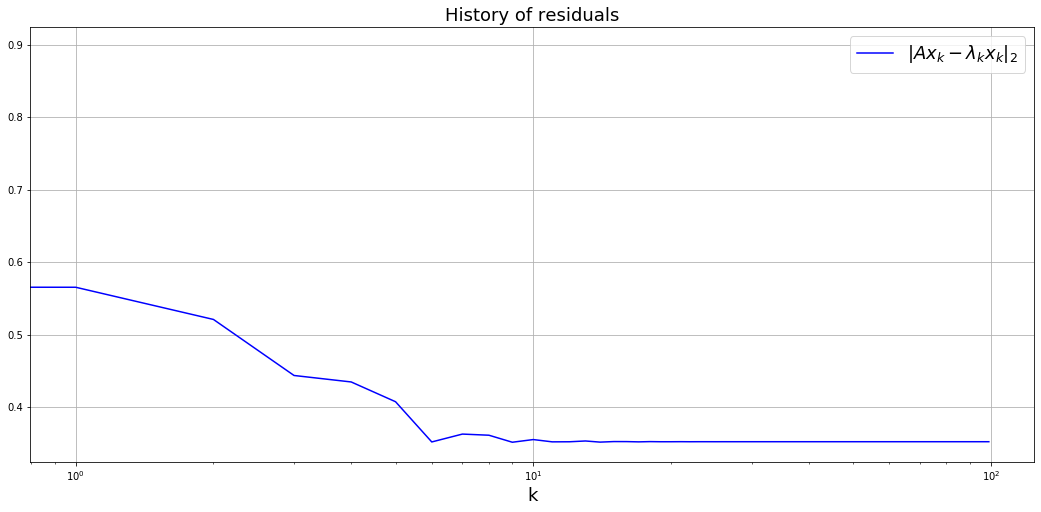

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))
plt.plot(res, 'b', label=r'$\|Ax_k - \lambda_k x_k\|_2$')
    
plt.grid()
plt.legend(loc='best', fontsize=18)
plt.xlabel('k', fontsize=18)
plt.title('History of residuals', fontsize=18)
plt.xscale('log')
plt.show()

The convergence ratio should be $\left|\frac{\lambda_2}{\lambda_1}\right| < 1$, but for our matrix this doesn't hold! Thehefore the Power-method doesn't converge.

In [96]:
lambdas[1] / lambdas[0]

1.2632281299019243

* (2 pts) Consider the same graph, but with additional self loop at node 4 (self loop is an edge that connects a vertex with itself). Plot residuals as in the previous task and discuss the convergence. Now, run the power method with ```num_iter=100``` for 10 different initial guesses and print/plot the resulting approximated eigenvectors. Why do they depend on the initial guess?

In [97]:
G_2 = G.copy()
G_2[4, 4] = 1
A_2 = pagerank_matrix(G_2)

iters = 10
residuals = []

for _ in range(iters):
    num_iter = 100
    x0 = np.random.rand(A_2.shape[0])
    v, l, res = power_method(A_2, x0, num_iter)
    residuals.append(res)

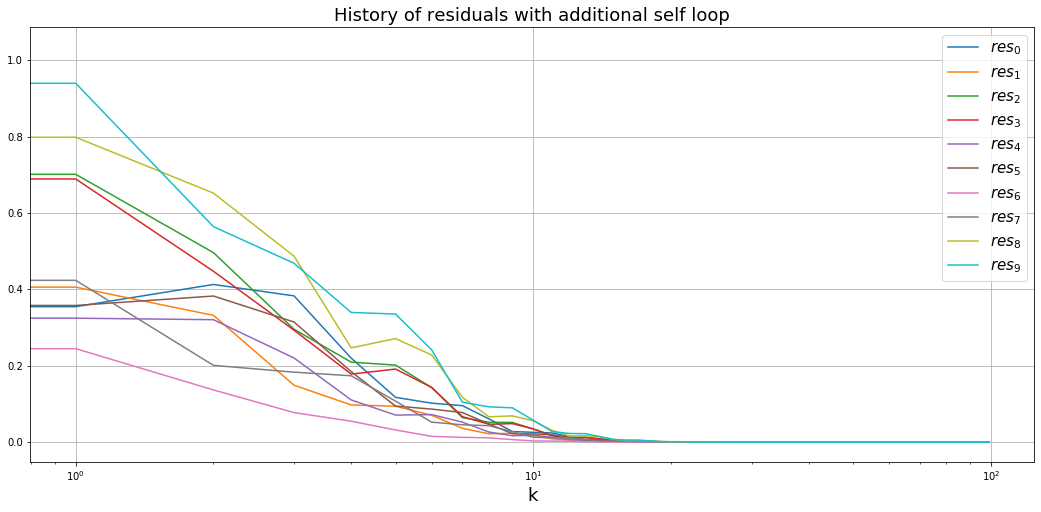

In [98]:
plt.figure(figsize=(18, 8))
for i, res in enumerate(residuals):
    plt.plot(res, label=fr'$res_{i}$')
    
plt.grid()
plt.legend(loc='best', fontsize=15)
plt.xlabel('k', fontsize=18)
plt.title('History of residuals with additional self loop', fontsize=18)
plt.xscale('log')
plt.show()

In order to avoid this problem Larry Page and Sergey Brin [proposed](http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf) to use the following regularization technique:

$$
A_d = dA + \frac{1-d}{N} \begin{pmatrix} 1 & \dots & 1 \\ \vdots & & \vdots \\ 1 & \dots & 1 \end{pmatrix},
$$

where $d$ is a small parameter in $[0,1]$ (typically $d=0.85$), which is called **damping factor**, $A$ is of size $N\times N$. Now $A_d$ is the matrix with multiplicity of the largest eigenvalue equal to 1. 
Recall that computing the eigenvector of the PageRank matrix, which corresponds to the largest eigenvalue, has the following interpretation. Consider a person who stays in a random node of a graph (i.e. opens a random web page); at each step s/he follows one of the outcoming edges uniformly at random (i.e. opens one of the links). So the person randomly walks through the graph and the eigenvector we are looking for is exactly his/her stationary distribution â€” for each node it tells you the probability of visiting this particular node. Therefore, if the person has started from a part of the graph which is not connected with the other part, he will never get there.  In the regularized model, the person at each step follows one of the outcoming links with probability $d$ OR teleports to a random node from the whole graph with probability $(1-d)$.

* (2 pts) Now, run the power method with $A_d$ and plot residuals $\|A_d x_k - \lambda_k x_k\|_2$ as a function of $k$ for $d=0.97$, ```num_iter=100``` and a random initial guess ```x0```.

* (5 pts) Find the second largest in the absolute value eigenvalue of the obtained matrix $A_d$. How and why is it connected to the damping factor $d$? What is the convergence rate of the PageRank algorithm when using damping factor?

In [99]:
d = 0.97
num_iter = 100
N = A.shape[0]

Ad = d*A + (1-d)/N * np.ones(A.shape)

iters = 10
residuals = []

for _ in range(iters):
    num_iter = 100
    x0 = np.random.rand(Ad.shape[0])
    v, l, res = power_method(Ad, x0, num_iter)
    residuals.append(res)

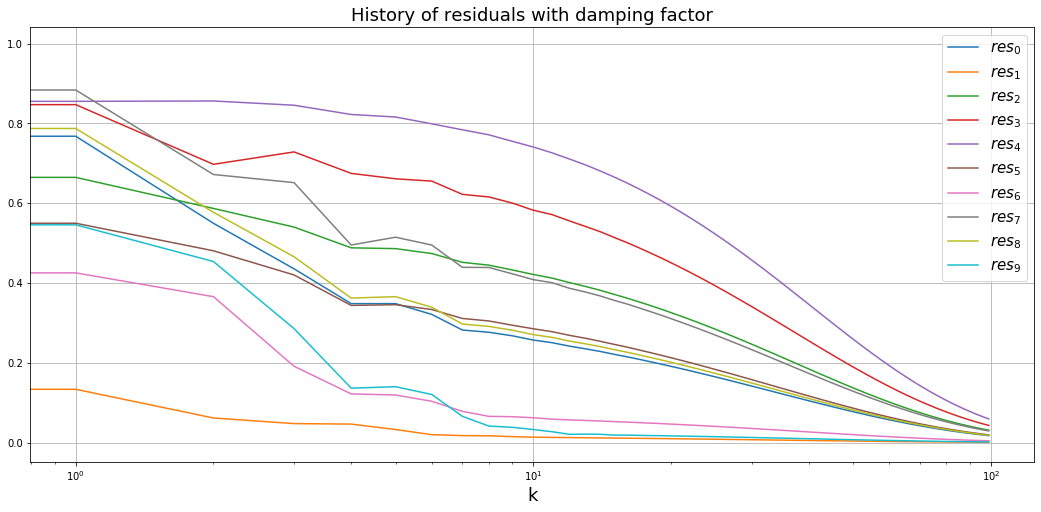

In [100]:
plt.figure(figsize=(18, 8))
for i, res in enumerate(residuals):
    plt.plot(res, label=fr'$res_{i}$')
    
plt.grid()
plt.legend(loc='best', fontsize=15)
plt.xlabel('k', fontsize=18)
plt.title('History of residuals with damping factor', fontsize=18)
plt.xscale('log')
plt.show()

In [101]:
Ad_eigs = LA.eigvals(Ad)
Ad_eigs_abs = np.abs(Ad_eigs)
print(Ad_eigs_abs)

[0.68589358 0.68589358 1.         0.97       0.97      ]


- A is left stochastic matrix then has eigenvalues which is equal 1 and we multiply A and d.

Usually, graphs that arise in various areas are sparse (social, web, road networks, etc.) and, thus, computation of a matrix-vector product for corresponding PageRank matrix $A$ is much cheaper than $\mathcal{O}(N^2)$. However, if $A_d$ is calculated directly, it becomes dense and, therefore, $\mathcal{O}(N^2)$ cost grows prohibitively large for  big $N$.


* (2 pts) Implement fast matrix-vector product for $A_d$ as a function ```pagerank_matvec(A, d, x)```, which takes a PageRank matrix $A$ (in sparse format, e.g., ```csr_matrix```), damping factor $d$ and a vector $x$ as an input and returns $A_dx$ as an output. 

* (1 pts) Generate a random adjacency matrix of size $10000 \times 10000$ with only 100 non-zero elements and compare ```pagerank_matvec``` performance with direct evaluation of $A_dx$.

In [102]:
# INPUT:  A - np.ndarray (2D), d - float (from 0.0 to 1.0), x - np.ndarray (1D, size of A.shape[0/1])
# OUTPUT: y - np.ndarray (1D, size of x)
def pagerank_matvec(A, d, x): # 2 pts
    # enter your code here
    N = A.shape[0]

    if issparse(A):
        ia = A.indptr
        ja = A.indices
        sa = A.data

        y = np.zeros_like(x)
        for i in range(N):
            for k in range(ia[i], ia[i+1]):
                y[i] += sa[k] * x[ja[k]]

        y *= d
        y += (1-d)/N * x.sum()

    else:
        Ad = d*A + (1-d)/N * np.ones(A.shape)
        y = np.dot(Ad, x)
        
    return y

In [103]:
n = 10000
m = 100
d = 0.97

array = np.array([1]*m + [0]*(n*n-m))
np.random.shuffle(array)

random_mat = array.reshape((n, n))
random_mat_sparse = csr_matrix(random_mat)
x = np.random.rand(n)

In [104]:
%time sparse_res = pagerank_matvec(random_mat_sparse, d, x)
%time res = pagerank_matvec(random_mat, d, x)

assert np.isclose(sparse_res, res).all(), 'Wrong sparse matvec product'
print('\nOK!')

CPU times: user 5.45 ms, sys: 330 µs, total: 5.78 ms
Wall time: 5.53 ms
CPU times: user 1.34 s, sys: 1.48 s, total: 2.82 s
Wall time: 2.26 s

OK!


#### DBLP: computer science bibliography

Download the dataset from [here](https://goo.gl/oZVxEa), unzip it and put `dblp_authors.npz`  and `dblp_graph.npz` in the same folder with this notebook. Each value (author name) from `dblp_authors.npz` corresponds to the row/column of the matrix from `dblp_graph.npz`. Value at row `i` and column `j` of the matrix from `dblp_graph.npz` corresponds to the number of times author `i` cited papers of the author `j`. Let us now find the most significant scientists according to PageRank model over DBLP data.

* (4 pts) Load the weighted adjacency matrix and the authors list into Python using ```load_dblp(...)``` function. Print its density (fraction of nonzero elements). Find top-10 most cited authors from the weighted adjacency matrix. Now, make all the weights of the adjacency matrix equal to 1 for simplicity (consider only existence of connection between authors, not its weight). Obtain the PageRank matrix $A$ from the adjacency matrix and verify that it is stochastic.

In [105]:
from scipy.sparse import load_npz
import numpy as np
def load_dblp(path_auth, path_graph):
    G = load_npz(path_graph).astype(float)
    with np.load(path_auth) as data: authors = data['authors']
    return G, authors

G_auth, authors = load_dblp('dblp_authors.npz', 'dblp_graph.npz')

In [106]:
# Your code is here

In [107]:
top = 10
print(f'Density: {G_auth.nnz/G_auth.shape[0]/G_auth.shape[1]:.1e}')

Density: 4.5e-05


In [108]:
cited_n = np.asarray(G_auth.sum(axis=0)).flatten()
top_ind = np.argsort(cited_n)[-top:]
print(authors[top_ind])

['David G. Lowe' 'David E. Culler' 'Ion Stoica' 'Jitendra Malik'
 'Cordelia Schmid' 'Anil K. Jain' 'Jiawei Han' 'Hari Balakrishnan'
 'Andrew Zisserman' 'Scott Shenker']


In [109]:
G_auth.data = np.ones(G_auth.nnz)

assert G_auth.data.sum() == G_auth.nnz, 'Weights is not equal an one.'

In [110]:
%%time
A_auth = pagerank_matrix(G_auth)

CPU times: user 19 s, sys: 1.16 s, total: 20.2 s
Wall time: 19.8 s


In [111]:
sum_of_col = np.asarray(A_auth.sum(axis=0)).flatten()
non_zero = np.where(~np.isclose(sum_of_col, 0))

assert sum_of_col[non_zero].sum() == sum_of_col[non_zero].shape[0], 'Matrix is not a stochastic'
print('OK!')

OK!


### 2.

* (1 pts) In order to provide ```pagerank_matvec``` to your ```power_method``` (without rewriting it) for fast calculation of $A_dx$, you can create a ```LinearOperator```: 
```python
L = scipy.sparse.linalg.LinearOperator(A.shape, matvec=lambda x, A=A, d=d: pagerank_matvec(A, d, x))
```
Calling ```L@x``` or ```L.dot(x)``` will result in calculation of ```pagerank_matvec(A, d, x)``` and, thus, you can plug $L$ instead of the matrix $A$ in the ```power_method``` directly. **Note:** though in the previous subtask graph was very small (so you could disparage fast matvec implementation), here it is very large (but sparse), so that direct evaluation of $A_dx$ will require $\sim 10^{12}$ matrix elements to store - good luck with that (^_<).

In [112]:
from scipy.sparse.linalg import LinearOperator

In [113]:
d = 0.85
L = LinearOperator(A_auth.shape, matvec=lambda x, A=A_auth, d=d: pagerank_matvec(A, d, x))

* (2 pts) Run the power method starting from the vector of all ones and plot residuals $\|A_dx_k - \lambda_k x_k\|_2$  as a function of $k$ for $d=0.85$.

In [118]:
%%time
num_iter = 5
x = np.ones(A_auth.shape[0])

v, l, res = power_method(L, x, num_iter)

CPU times: user 9min 30s, sys: 1.2 s, total: 9min 31s
Wall time: 9min 31s


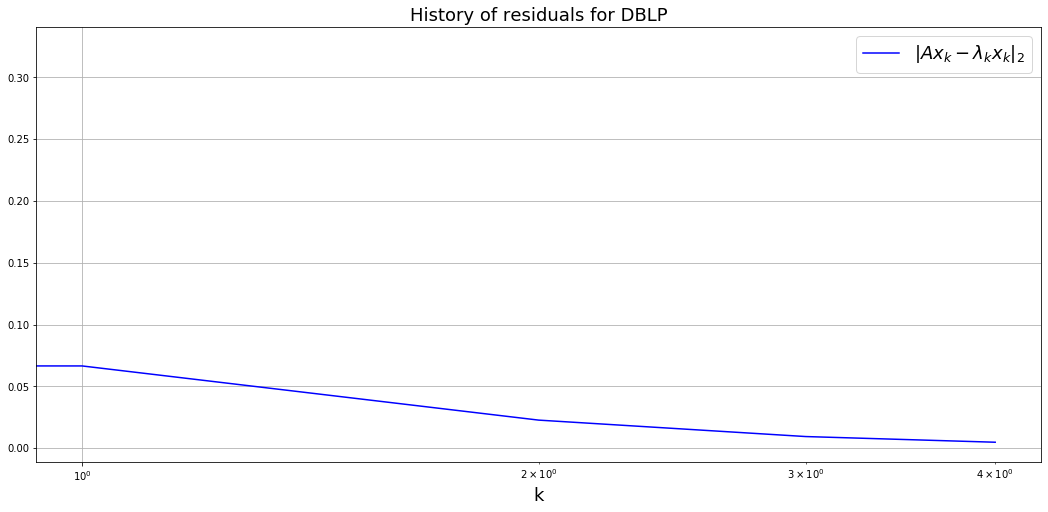

In [119]:
plt.figure(figsize=(18, 8))
plt.plot(res, 'b', label=r'$\|Ax_k - \lambda_k x_k\|_2$')
    
plt.grid()
plt.legend(loc='best', fontsize=18)
plt.xlabel('k', fontsize=18)
plt.title('History of residuals for DBLP', fontsize=18)
plt.xscale('log')
plt.show()

* (1 pts) Print names of the top-10 authors according to PageRank over DBLP when $d=0.85$. Comment on your findings.

In [120]:
top_authors_ind = np.argsort(v)[-10:]
authors[top_authors_ind]

array(['Jovan Aleksić', 'Dale Chambers', 'Katya P. Tsvetkova',
       'Yeliz Cavusoglu', 'Pu Dong', 'J.A. Wong-Loya', 'Matteo Maino',
       'Stefano Cuccuru', 'Antonio Puccini', 'Giacomo Oggiano'],
      dtype='<U98')